## 4. PyTorch tour: tensors, graphs, operations, efficiency, dtypes, devices

This section is deliberately code-heavy.

In class, I will run these examples live. In the notes, each concept is paired with a minimal runnable snippet.

### 4.1 Conventions for the code blocks

- Every snippet is meant to run in a fresh Python process.
- If a line prints something, I show the output as a comment.
- If output depends on hardware (CPU vs GPU) or timing, I label it as example output.

### 4.2 Tensors in higher dimensions: creation

A tensor is a container for numbers, plus metadata:

- shape,
- dtype,
- device,
- (optionally) autodiff tracking.

#### From Python lists



In [43]:
import torch

x = torch.tensor([1.0, 2.0, 3.0])
A = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])

print("x:", x)
print("A:\n", A)
print("x.shape:", x.shape)
print("A.shape:", A.shape)

# Output:
# x: tensor([1., 2., 3.])
# A:
#  tensor([[1, 2, 3],
#          [4, 5, 6]])
# x.shape: torch.Size([3])
# A.shape: torch.Size([2, 3])


x: tensor([1., 2., 3.])
A:
 tensor([[1, 2, 3],
        [4, 5, 6]])
x.shape: torch.Size([3])
A.shape: torch.Size([2, 3])



#### Indexing with `[]` and `:`

Use `[]` to access elements and slices. `:` means “all entries along that axis.” `-1` means “last.”



In [44]:
import torch

x = torch.tensor([10.0, 20.0, 30.0, 40.0])
A = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])

print("x[0]:", x[0])
print("x[-1]:", x[-1])
print("x[1:3]:", x[1:3])
print("A[0, 1]:", A[0, 1])
print("A[1, :]:", A[1, :])
print("A[:, -1]:", A[:, -1])

# Output:
# x[0]: tensor(10.)
# x[-1]: tensor(40.)
# x[1:3]: tensor([20., 30.])
# A[0, 1]: tensor(2)
# A[1, :]: tensor([4, 5, 6])
# A[:, -1]: tensor([3, 6, 9])


x[0]: tensor(10.)
x[-1]: tensor(40.)
x[1:3]: tensor([20., 30.])
A[0, 1]: tensor(2)
A[1, :]: tensor([4, 5, 6])
A[:, -1]: tensor([3, 6, 9])



#### From and to NumPy

Two important facts:

1. `torch.from_numpy(np_array)` shares memory with NumPy (zero-copy).
2. `.numpy()` shares memory with the tensor when the tensor is on CPU.



In [45]:
import numpy as np
import torch

a_np = np.array([[1.0, 2.0],
                 [3.0, 4.0]], dtype=np.float32)

a_t = torch.from_numpy(a_np)

print("a_t:\n", a_t)
print("same memory?", a_t.data_ptr() == a_np.__array_interface__["data"][0])

a_np[0, 0] = 999.0
print("after modifying numpy, a_t:\n", a_t)

# Output:
# a_t:
#  tensor([[1., 2.],
#          [3., 4.]])
# same memory? True
# after modifying numpy, a_t:
#  tensor([[999.,   2.],
#          [  3.,   4.]])


a_t:
 tensor([[1., 2.],
        [3., 4.]])
same memory? True
after modifying numpy, a_t:
 tensor([[999.,   2.],
        [  3.,   4.]])



One might think `.numpy()` is a “copy out.” However, on CPU it is typically a view into the same storage. If you need a copy, use `.clone()` first.

#### Random tensors

Gaussian and uniform are the workhorses:



In [46]:
import torch

torch.manual_seed(0)

g = torch.randn(2, 3)   # N(0,1)
u = torch.rand(2, 3)    # Unif[0,1)

print("g:\n", g)
print("u:\n", u)

# Output:
# g:
#  tensor([[ 1.5410, -0.2934, -2.1788],
#          [ 0.5684, -1.0845, -1.3986]])
# u:
#  tensor([[0.4963, 0.7682, 0.0885],
#          [0.1320, 0.3074, 0.6341]])


g:
 tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])
u:
 tensor([[0.0223, 0.1689, 0.2939],
        [0.5185, 0.6977, 0.8000]])



#### `empty`: uninitialized memory



In [47]:
import torch

x = torch.empty(2, 3)
print(x)

# Output:
# tensor([[... random-looking values ...]])


tensor([[0., 0., 0.],
        [0., 0., 0.]])



Why would you ever do this?

- `torch.empty` allocates memory but does not fill it.
- If you are about to overwrite every entry anyway, `empty` avoids an unnecessary initialization pass.

A common pattern is:

- allocate with `empty`,
- fill with some computation.

#### Zeros and ones



In [48]:
import torch

z = torch.zeros(2, 3)
o = torch.ones(2, 3)

print("zeros:\n", z)
print("ones:\n", o)

# Output:
# zeros:
#  tensor([[0., 0., 0.],
#          [0., 0., 0.]])
# ones:
#  tensor([[1., 1., 1.],
#          [1., 1., 1.]])


zeros:
 tensor([[0., 0., 0.],
        [0., 0., 0.]])
ones:
 tensor([[1., 1., 1.],
        [1., 1., 1.]])



#### Reference/clone

Two things that look similar in Python are not the same in PyTorch:

- assignment creates a reference (same storage, same graph),
- `clone()` copies data (new storage, graph connection preserved).



In [49]:
import torch

x = torch.tensor([1.0, 2.0, 3.0])

y = x              # reference (no new memory)
z = x.clone()      # data copy (new memory)

print("x.data_ptr:", x.data_ptr())
print("y.data_ptr:", y.data_ptr())
print("z.data_ptr:", z.data_ptr())

y[0] = 999.0
print("after y[0]=999:")
print("x:", x)
print("y:", y)
print("z:", z)

# Output:
# x.data_ptr:  ...
# y.data_ptr:  ... (same as x)
# z.data_ptr:  ... (different)
# after y[0]=999:
# x: tensor([999.,   2.,   3.])
# y: tensor([999.,   2.,   3.])
# z: tensor([1., 2., 3.])


x.data_ptr: 4834679232
y.data_ptr: 4834679232
z.data_ptr: 4834721280
after y[0]=999:
x: tensor([999.,   2.,   3.])
y: tensor([999.,   2.,   3.])
z: tensor([1., 2., 3.])



So:

- “copy” in casual Python talk often means “another name for the same object.”
- `clone()` means “a new tensor with its own storage.”
- if `x` is tracked, `x.clone()` is still attached to the computation graph; use `x.detach().clone()` to copy without the graph.

### 4.3 Tensor manipulation: shape, reshape, view, concat, squeeze

#### `.numel` and `.shape`

Access to tensor shape and number of elements.



In [50]:
import torch

A = torch.randn(2, 3, 4)
print("A.shape:", A.shape)
print("A.numel():", A.numel())

# Output:
# A.shape: torch.Size([2, 3, 4])
# A.numel(): 24


A.shape: torch.Size([2, 3, 4])
A.numel(): 24



#### Memory layout: contiguous vs non-contiguous

Aside: this will help with `reshape`/`view` below, and it will matter for efficiency later. PyTorch is row-major (C-order) by default, so the last index changes fastest in memory.

PyTorch tensors have **strides**, which describe how to step through memory to move along each dimension. Concretely, the stride tuple tells you how many *elements* you jump in the underlying 1D storage when you increment an index by 1 along each axis.

Example: for a 3×4 row-major tensor, a stride of `(4, 1)` means “move 4 elements to go down one row, move 1 element to go right one column.”

The default layout for a 2D tensor is row-major contiguous in the sense that the last dimension is contiguous.

Transpose changes the stride pattern without moving data.



In [51]:
import torch

A = torch.arange(12).reshape(3, 4)
AT = A.t()

print("A.shape:", A.shape, "stride:", A.stride(), "contiguous:", A.is_contiguous())
print("AT.shape:", AT.shape, "stride:", AT.stride(), "contiguous:", AT.is_contiguous())

# Output:
# A.shape: torch.Size([3, 4]) stride: (4, 1) contiguous: True
# AT.shape: torch.Size([4, 3]) stride: (1, 4) contiguous: False


A.shape: torch.Size([3, 4]) stride: (4, 1) contiguous: True
AT.shape: torch.Size([4, 3]) stride: (1, 4) contiguous: False



**Figure 3.5: row-major vs column-major intuition.**  
![Row-major vs column-major memory layout](figures/memory_layout_row_vs_col.png)
*Figure 3.5: A 2D array is stored in 1D memory. Row-major means row entries are contiguous. Column-major means column entries are contiguous. Strides are the precise way to describe both.*

We will talk about efficiency considerations later, but an actionable rule is:

- if you see `is_contiguous()` is `False` and performance matters, consider making a contiguous copy with `.contiguous()` at an appropriate point.

#### `reshape`: change shape (maybe copy)



In [52]:
import torch

x = torch.arange(12)     # 0,1,...,11
A = x.reshape(3, 4)

print("x:", x)
print("A:\n", A)
print("A.shape:", A.shape)

# Output:
# x: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
# A:
#  tensor([[ 0,  1,  2,  3],
#          [ 4,  5,  6,  7],
#          [ 8,  9, 10, 11]])
# A.shape: torch.Size([3, 4])


x: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
A:
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
A.shape: torch.Size([3, 4])



You can use `-1` to infer a dimension:



In [53]:
import torch

x = torch.arange(12)
B = x.reshape(2, -1)

print("B.shape:", B.shape)
print("B:\n", B)

# Output:
# B.shape: torch.Size([2, 6])
# B:
#  tensor([[ 0,  1,  2,  3,  4,  5],
#          [ 6,  7,  8,  9, 10, 11]])


B.shape: torch.Size([2, 6])
B:
 tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])



#### `view`: change shape without copying (requires contiguous layout)

A `view` is a different interpretation of the same memory.

One might think `reshape` and `view` are identical. However:

- `view` requires the tensor to be contiguous in memory,
- `reshape` will return a view when possible, and otherwise it will copy.

So when the tensor is contiguous, `view` and `reshape` are identical: both return a view with no data copy.

A standard way to make a non-contiguous tensor is transpose.



In [54]:
import torch

x = torch.arange(12)
A = x.view(3, 4)   # standalone view example (x is contiguous)
AT = A.t()         # transpose: shape (4,3)

print("A from view:\n", A)
print("A.is_contiguous():", A.is_contiguous())
print("AT.is_contiguous():", AT.is_contiguous())

# Output:
# A from view:
#  tensor([[ 0,  1,  2,  3],
#          [ 4,  5,  6,  7],
#          [ 8,  9, 10, 11]])
# A.is_contiguous(): True
# AT.is_contiguous(): False


A from view:
 tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
A.is_contiguous(): True
AT.is_contiguous(): False



Now compare `view` vs `reshape`:



In [55]:
import torch

A = torch.arange(12).reshape(3, 4)
AT = A.t()

try:
    v = AT.view(-1)
    print("view worked:", v)
except RuntimeError as e:
    print("view failed:", e)

r = AT.reshape(-1)
print("reshape worked:", r)

# Output:
# view failed: view size is not compatible with input tensor's size and stride ...
# reshape worked: tensor([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])


view failed: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.
reshape worked: tensor([ 0,  4,  8,  1,  5,  9,  2,  6, 10,  3,  7, 11])



#### Concatenation: vertical and horizontal

For 2D tensors:

- concatenate “vertically” means `dim=0` (stack rows),
- concatenate “horizontally” means `dim=1` (stack columns).



In [56]:
import torch

A = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
B = torch.tensor([[10, 20, 30],
                  [40, 50, 60]])

V = torch.cat([A, B], dim=0)  # vertical
H = torch.cat([A, B], dim=1)  # horizontal

print("V.shape:", V.shape)
print("V:\n", V)
print("H.shape:", H.shape)
print("H:\n", H)

# Output:
# V.shape: torch.Size([4, 3])
# V:
#  tensor([[ 1,  2,  3],
#          [ 4,  5,  6],
#          [10, 20, 30],
#          [40, 50, 60]])
# H.shape: torch.Size([2, 6])
# H:
#  tensor([[ 1,  2,  3, 10, 20, 30],
#          [ 4,  5,  6, 40, 50, 60]])


V.shape: torch.Size([4, 3])
V:
 tensor([[ 1,  2,  3],
        [ 4,  5,  6],
        [10, 20, 30],
        [40, 50, 60]])
H.shape: torch.Size([2, 6])
H:
 tensor([[ 1,  2,  3, 10, 20, 30],
        [ 4,  5,  6, 40, 50, 60]])



Shape compatibility matters:



In [57]:
import torch

A = torch.zeros(2, 3)
C = torch.zeros(3, 3)

try:
    torch.cat([A, C], dim=1)
except RuntimeError as e:
    print("concat failed:", e)

# Output:
# concat failed: Sizes of tensors must match except in dimension 1 ...


concat failed: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 3 for tensor number 1 in the list.



#### `squeeze` and `unsqueeze`

Sometimes your tensor has a dimension of size 1 that you want to remove (squeeze), or you want to add a size-1 dimension to make shapes align (unsqueeze).



In [58]:
import torch

v = torch.tensor([1.0, 2.0, 3.0])   # shape (3,)
v_row = v.unsqueeze(0)              # shape (1,3)
v_col = v.unsqueeze(1)              # shape (3,1)

print("v.shape:", v.shape)
print("v_row.shape:", v_row.shape)
print("v_col.shape:", v_col.shape)

# Output:
# v.shape: torch.Size([3])
# v_row.shape: torch.Size([1, 3])
# v_col.shape: torch.Size([3, 1])


v.shape: torch.Size([3])
v_row.shape: torch.Size([1, 3])
v_col.shape: torch.Size([3, 1])



A practical use: concatenating a single row onto a matrix.



In [ ]:
import torch

A = torch.zeros(2, 3)
v = torch.tensor([1.0, 2.0, 3.0])


try:
    A1 = torch.cat([A, v], dim=0)
except RuntimeError as e:
    print("concat failed:", e)

A2 = torch.cat([A, v.unsqueeze(0)], dim=0)
print("A2.shape:", A2.shape)
print(A2)

# Output:
# A2.shape: torch.Size([3, 3])
# tensor([[0., 0., 0.],
#         [0., 0., 0.],
#         [1., 2., 3.]])


concat failed: Tensors must have same number of dimensions: got 2 and 1
A2.shape: torch.Size([3, 3])
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [1., 2., 3.]])



### 4.4 A larger tour of the PyTorch API

This is a short tour of things you will use constantly.

#### Entrywise operations

Any scalar function can be applied entrywise.



In [91]:
import torch

x = torch.tensor([1.0, 2.0, 3.0])

print("exp:", torch.exp(x))
print("log:", torch.log(x))
print("sin:", torch.sin(x))
print("x**2:", x**2)
print("x*x:", x*x)

# Output:
# exp: tensor([ 2.7183,  7.3891, 20.0855])
# log: tensor([0.0000, 0.6931, 1.0986])
# sin: tensor([0.8415, 0.9093, 0.1411])
# x**2: tensor([1., 4., 9.])
# x*x: tensor([1., 4., 9.])


exp: tensor([ 2.7183,  7.3891, 20.0855])
log: tensor([0.0000, 0.6931, 1.0986])
sin: tensor([0.8415, 0.9093, 0.1411])
x**2: tensor([1., 4., 9.])
x*x: tensor([1., 4., 9.])



Two ways to square a vector (`x**2` vs `x*x`) are equivalent here.

#### Reductions replace loops

Reductions compute aggregates over dimensions.



In [92]:
import torch

A = torch.tensor([[1.0, 2.0],
                  [3.0, 4.0]])

print("sum all:", A.sum().item())
print("sum dim=0:", A.sum(dim=0))
print("sum dim=1:", A.sum(dim=1))
print("mean:", A.mean().item())
print("max:", A.max().item())
print("argmax (flattened):", A.argmax().item())

# Output:
# sum all: 10.0
# sum dim=0: tensor([4., 6.])
# sum dim=1: tensor([3., 7.])
# mean: 2.5
# max: 4.0
# argmax (flattened): 3


sum all: 10.0
sum dim=0: tensor([4., 6.])
sum dim=1: tensor([3., 7.])
mean: 2.5
max: 4.0
argmax (flattened): 3




#### Basic linear algebra



In [93]:
import torch

A = torch.tensor([[1.0, 2.0],
                  [3.0, 4.0]])
x = torch.tensor([10.0, 20.0])

print("A.T:\n", A.t())
print("A @ x:", (A @ x))
print("x @ x:", (x @ x))   # inner product for 1D tensors
print("||x||:", torch.norm(x))

# Output:
# A.T:
#  tensor([[1., 3.],
#          [2., 4.]])
# A @ x: tensor([ 50., 110.])
# x @ x: tensor(500.)
# ||x||: tensor(...)


A.T:
 tensor([[1., 3.],
        [2., 4.]])
A @ x: tensor([ 50., 110.])
x @ x: tensor(500.)
||x||: tensor(22.3607)



#### Matrix-matrix multiplication



In [94]:
import torch

A = torch.randn(2, 3)
B = torch.randn(3, 4)
C = A @ B

print("C.shape:", C.shape)

# Output:
# C.shape: torch.Size([2, 4])


C.shape: torch.Size([2, 4])



What about “multiplying tensors” beyond matrices?

- `@` and `torch.matmul` generalize matrix multiplication to batched dimensions.
- The semantics are precise, but you need to know what dimensions are treated as batch vs matrix dimensions.
- Later we will use `einsum` because it forces you to be explicit about index contractions.

#### Logical ops and masking



In [95]:
import torch

x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0])
mask = x > 0

print("mask:", mask)
print("x[mask]:", x[mask])

# Output:
# mask: tensor([False, False, False,  True,  True])
# x[mask]: tensor([1., 2.])


mask: tensor([False, False, False,  True,  True])
x[mask]: tensor([1., 2.])



#### Loss functions: `torch.nn.functional`

PyTorch has common losses implemented and numerically stabilized.

Two functions you should know exist:

- `torch.logsumexp`,
- `torch.nn.functional.cross_entropy` and `binary_cross_entropy_with_logits`.

#### Logistic regression for spam vs not-spam (vectorized)

We will write the whole “model + loss” in code.

Setup:

- data matrix $X \in \mathbb{R}^{n \times d}$,
- labels $y \in \{0,1\}^n$,
- parameter vector $w \in \mathbb{R}^d$,
- logits $z = Xw$,
- loss = binary cross entropy on logits.



In [96]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)

n = 8
d = 5

X = torch.randn(n, d)
y = torch.randint(low=0, high=2, size=(n,)).float()  # 0/1 labels

w = torch.randn(d, requires_grad=True)

logits = X @ w                      # shape (n,)
loss = F.binary_cross_entropy_with_logits(logits, y)

print("logits.shape:", logits.shape)
print("loss:", loss.item())

# Output:
# logits.shape: torch.Size([8])
# loss: ...


logits.shape: torch.Size([8])
loss: 1.3334670066833496




One thing you should note: We used `binary_cross_entropy_with_logits`, not “sigmoid then BCE.” The logits version is more numerically stable.


#### `torch.nn`: a tiny two-layer network

A linear model predicts with $x^\top w$. A neural network predicts with a nonlinear mapping.

We will build:

- Linear layer: $\mathbb{R}^d \to \mathbb{R}^h$,
- ReLU,
- Linear layer: $\mathbb{R}^h \to \mathbb{R}$.

**Figure 3.3: two-layer network architecture.**  
![Two-layer network](figures/two_layer_network.png)
*Figure 3.3: A simple 2-layer MLP: linear layer, ReLU, linear layer. Later we will replace this with transformer blocks.*



In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

n = 8
d = 5
h = 16

X = torch.randn(n, d)
y = torch.randint(low=0, high=2, size=(n,)).float()

model = nn.Sequential(
    nn.Linear(d, h),
    nn.ReLU(),
    nn.Linear(h, 1),
)

logits = model(X).squeeze(1)     # shape (n,)
loss = F.binary_cross_entropy_with_logits(logits, y)

print("logits.shape:", logits.shape)
print("loss:", loss.item())

# Output:
# logits.shape: torch.Size([8])
# loss: ...


logits.shape: torch.Size([8])
loss: 0.6901422142982483




### 4.5 Computational graphs in higher dimensions

We're going to go a bit more in-depth on gradient tracking. 

#### `requires_grad`: turning tracking on



In [67]:
import torch

w = torch.randn(5, requires_grad=True)
L = 0.5 * (w * w).sum()
L.backward()

print("w:", w)
print("grad:", w.grad)

# Output:
# w: tensor([...], requires_grad=True)
# grad: tensor([...])   # should equal w


w: tensor([ 0.3792,  1.6658,  0.2601,  0.4246, -0.5017], requires_grad=True)
grad: tensor([ 0.3792,  1.6658,  0.2601,  0.4246, -0.5017])



#### Why you “can’t just assign into” a leaf tensor requiring grad

A **leaf tensor** is one that was created by you (not the result of an operation) and has `requires_grad=True`. It is the starting node that accumulates gradients in `.grad`.

If `w` is a leaf tensor with `requires_grad=True`, in-place modifications can break the recorded computation.



In [68]:
import torch

w = torch.randn(3, requires_grad=True)

try:
    w[0] = 0.0
except RuntimeError as e:
    print("in-place assignment failed:", e)

# Output:
# in-place assignment failed: a view of a leaf Variable that requires grad is being used in an in-place operation.


in-place assignment failed: a view of a leaf Variable that requires grad is being used in an in-place operation.



A standard pattern is:

1. create a tensor,
2. do any preprocessing (normalization, clipping),
3. then turn on grad tracking.



In [69]:
import torch

w = torch.randn(3)
w = w / w.norm()          # preprocessing while not tracking gradients
w.requires_grad_()        # now start tracking

L = 0.5 * (w * w).sum()
L.backward()

print("w.requires_grad:", w.requires_grad)
print("w.grad:", w.grad)

# Output:
# w.requires_grad: True
# w.grad: tensor([...])


w.requires_grad: True
w.grad: tensor([ 0.3349,  0.6936, -0.6377])



#### `detach`: stop tracking, but keep the same storage

`detach()` returns a tensor that shares memory with the original tensor, but is not connected to the computational graph.

Two key questions:

1. Does it point to the same memory?  
2. If you modify the detached tensor, does the original change?

Yes to both.



In [70]:
import torch

w = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
v = w.detach()

print("same storage?", w.data_ptr() == v.data_ptr())

v[0] = 999.0
print("after modifying v:")
print("w:", w)
print("v:", v)

# Output:
# same storage? True
# after modifying v:
# w: tensor([999.,   2.,   3.], requires_grad=True)
# v: tensor([999.,   2.,   3.])


same storage? True
after modifying v:
w: tensor([999.,   2.,   3.], requires_grad=True)
v: tensor([999.,   2.,   3.])



This is useful and dangerous.

Useful when:

- you want a non-tracked view for logging,
- you want to stop gradient tracking for a subcomputation.

Dangerous when:

- you modify the detached tensor and accidentally mutate the tracked parameters.

If you need a non-tracked copy that is safe to mutate, you want `detach().clone()`.

#### `clone`: copy data

We revisit `clone()` here because now we care about autograd, not just storage. The key point: `clone()` copies the data but **preserves the computation graph** when the source is tracked.

`clone()` makes a new tensor with its own storage.

If you clone a tracked tensor, the clone is still connected to the graph (it is not a leaf). Because it is non-leaf, its `.grad` is not populated by default; gradients accumulate on the original leaf unless you call `retain_grad()` on the clone.



In [71]:
import torch

w = torch.randn(3, requires_grad=True)
c = w.clone()

print("w.is_leaf:", w.is_leaf)
print("c.is_leaf:", c.is_leaf)

L = (c * c).sum()
L.backward()

print("w.grad:", w.grad)

# Output:
# w.is_leaf: True
# c.is_leaf: False
# w.grad: tensor([...])


w.is_leaf: True
c.is_leaf: False
w.grad: tensor([ 3.2767, -1.3485, -0.7248])



So `clone()` is a data copy, but not a “stop gradient,” meaning gradients still flow back through it.

If you want a copy that is disconnected from the graph:



In [72]:
import torch

w = torch.randn(3, requires_grad=True)
snap = w.detach().clone()

print("snap.requires_grad:", snap.requires_grad)
print("same storage?", w.data_ptr() == snap.data_ptr())

# Output:
# snap.requires_grad: False
# same storage? False


snap.requires_grad: False
same storage? False



#### When do we use `detach().clone()` in practice?

Whenever you want to store values without storing the graph.

Common patterns:

- logging parameter snapshots during training,
- exponential moving averages (EMA) of weights,


#### Autodiff reminder: recorded operations + chain rule

When you write a loss in PyTorch, you are giving PyTorch a computational graph.

In math terms, you are expressing $L$ as a composition:

$$
L = g \circ h \circ r \circ \cdots
$$

PyTorch applies the multivariate chain rule through that recorded composition.

We are not proving the multivariate chain rule here. If you want a clean Jacobian-based explanation, see:

- <https://damek.github.io/STAT-4830/archive/2025/section/5/notes.html#extending-to-higher-dimensions-the-jacobian>

### 4.6 Lingering question: what happens if `backward()` sees a non-scalar tensor?

`backward()` computes derivatives of a scalar loss.

One might think you can do:

- compute a vector output,
- call `backward()`.

But a vector output does not have “the gradient” in the sense we need for optimization. It has a **Jacobian**.

Definition: if $f:\mathbb{R}^d \to \mathbb{R}^m$, the Jacobian is the $m \times d$ matrix of partial derivatives
$$
J_{ij} = \frac{\partial f_i}{\partial x_j}.
$$

PyTorch resolves this by defaulting to **vector–Jacobian products**.

Concretely:

- if `y` is non-scalar, `y.backward()` is ambiguous unless you specify a vector to multiply the Jacobian by.

Here is the failure mode:



In [73]:
import torch

w = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = w * w   # y is vector-valued

try:
    y.backward()
except RuntimeError as e:
    print("backward failed:", e)

# Output:
# backward failed: grad can be implicitly created only for scalar outputs


backward failed: grad can be implicitly created only for scalar outputs



With `backward`, you can pass a vector `v` and get a Jacobian–vector product.



In [74]:
import torch

w = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = w * w

v = torch.tensor([10.0, 20.0, 30.0])   # same shape as y
y.backward(v)

print("w.grad:", w.grad)

# Output:
# w.grad: tensor([ 20.,  80., 180.])


w.grad: tensor([ 20.,  80., 180.])



Example (quadratic vector):

- $y = (w_1^2,w_2^2,w_3^2)$ has Jacobian $J=\mathrm{diag}(2w_1,2w_2,2w_3)$,
- `y.backward(v)` computes $J^\top v$,
- here that is $(2w_1 v_1,2w_2 v_2,2w_3 v_3)$.

### 4.7 Dtypes: precision, speed, and accumulation

PyTorch supports multiple numeric types.

Common ones:

- floating point: `float16`, `bfloat16`, `float32`, `float64`,
- integers: `int32`, `int64`,
- booleans: `bool`.


What does “precision” mean?

A floating-point number stores three fields: sign, exponent, and mantissa (significand). The exponent sets the scale (where the decimal point sits); the mantissa stores the significant digits. Different float types allocate bits differently.

**Figure 3.8: floating-point bit layouts (sign, exponent, mantissa).**  
![Floating-point bit layouts](figures/float_bit_layout.png)  
*Figure 3.8: The exponent controls scale (range); the mantissa controls precision. bfloat16 keeps the float32 exponent width but fewer mantissa bits.*

Lower precision means fewer mantissa bits. That cuts memory and often increases throughput on modern accelerators, but it increases rounding error and can make some computations inaccurate.

When training large language models, it is common for a model to have many groups of parameters, and each group can use a different precision level.

Figuring out which precision is write for your problem is a matter of trial and error. One practical rule of thumb that always applies is to keep accumulators in high precision. What's an accumulator? It is a variable that holds a running sum (loss totals, gradient sums), and rounding error compounds there.
  

#### Accumulation exercise (float16 vs float32)



In [75]:
import torch

# 1000 copies of ~0.01 should sum to ~10.
n = 1000
vals32 = torch.full((n,), 0.0100001, dtype=torch.float32)
vals16 = vals32.to(torch.float16)

# float32 accumulator + float32 values
acc32_32 = torch.tensor(0.0, dtype=torch.float32)
for v in vals32:
    acc32_32 = acc32_32 + v

# float16 accumulator + float16 values
acc16_16 = torch.tensor(0.0, dtype=torch.float16)
for v in vals16:
    acc16_16 = acc16_16 + v

# float32 accumulator + float16 values (implicit upcast of v during addition)
acc32_16 = torch.tensor(0.0, dtype=torch.float32)
for v in vals16:
    acc32_16 = acc32_16 + v

# float32 accumulator + float16 values (explicit upcast)
acc32_16_explicit = torch.tensor(0.0, dtype=torch.float32)
for v in vals16:
    acc32_16_explicit = acc32_16_explicit + v.to(torch.float32)

print("float32 accumulator + float32 values:", acc32_32)
print("float16 accumulator + float16 values:", acc16_16)
print("float32 accumulator + float16 values (implicit upcast):", acc32_16)
print("float32 accumulator + float16 values (explicit upcast):", acc32_16_explicit)

# Output:
# float32 accumulator + float32 values: tensor(10.0001)
# float16 accumulator + float16 values: tensor(9.9531, dtype=torch.float16)
# float32 accumulator + float16 values (implicit upcast): tensor(10.0021)
# float32 accumulator + float16 values (explicit upcast): tensor(10.0021)


float32 accumulator + float32 values: tensor(10.0002)
float16 accumulator + float16 values: tensor(9.9531, dtype=torch.float16)
float32 accumulator + float16 values (implicit upcast): tensor(10.0021)
float32 accumulator + float16 values (explicit upcast): tensor(10.0021)



Interpretation:

- `float16` cannot represent `0.0100001` exactly; it rounds it.
- `float16` accumulation loses additional information because the accumulator itself cannot represent intermediate sums finely.
- `float32` accumulation avoids the accumulator-rounding issue, but you still sum the rounded `float16` values, so you can end up slightly high.




### 4.8 Efficiency issues

Throughout this section, we will:

- do the same computation two ways,
- time them,
- explain why one is better.

Timing is hardware-dependent. You should focus on the order-of-magnitude differences and the reasons, not the exact numbers.

#### In-place operations: the `_` suffix

An **in-place** operation writes its result into the existing tensor’s memory instead of allocating a new tensor.

Many PyTorch operations have an in-place version with a trailing underscore.

Example: `add_` modifies a tensor in place.




In [76]:
import torch

x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor([10.0, 20.0, 30.0])

x_out = x + y
print("out-of-place:", x_out)
print("x unchanged:", x)

x_in = x.clone()
x_in.add_(y)
print("in-place:", x_in)

# Output:
# out-of-place: tensor([11., 22., 33.])
# x unchanged: tensor([1., 2., 3.])
# in-place: tensor([11., 22., 33.])


out-of-place: tensor([11., 22., 33.])
x unchanged: tensor([1., 2., 3.])
in-place: tensor([11., 22., 33.])



Why in-place?

- it avoids allocating a new tensor,
- it can reduce memory traffic.

One might think “always use in-place for speed.” However:

- in-place ops can break autodiff if they overwrite values needed for backward,
- in-place ops can make code harder to reason about.

In training loops, the common safe in-place updates happen under `torch.no_grad()`.

Finally, note that `x = x + y` is **out-of-place** (it allocates a new tensor and rebinds `x`).

#### Broadcasting: matrix–vector Hadamard product

Broadcasting is a rule that lets PyTorch align tensors with different shapes by “stretching” size‑1 dimensions, without allocating the repeated data.

In this section we give a row‑wise example: a vector multiplies each row of a matrix (Hadamard product).

We want to compute:

- matrix $A \in \mathbb{R}^{n \times d}$,
- vector $v \in \mathbb{R}^d$,
- result $B \in \mathbb{R}^{n \times d}$ where $B_{ij} = A_{ij} v_j$.

There are three conceptual ways:

1. Python for-loop (slow, sequential),
2. explicitly repeat the vector into a matrix (extra memory),
3. broadcasting (no extra memory for the repeated matrix).

**Figure 3.4: broadcasting as “virtual replication.”**  
![Broadcasting matrix-vector Hadamard](figures/broadcasting_matrix_vector.png)
*Figure 3.4: Broadcasting behaves like repeating a vector across rows, but without allocating the repeated matrix.*

Code:



In [77]:
import torch

torch.manual_seed(0)

n = 4
d = 3

A = torch.randn(n, d)
v = torch.randn(d)

B = A * v   # broadcasting: v treated as shape (1,d) and expanded across rows

print("A.shape:", A.shape)
print("v.shape:", v.shape)
print("B.shape:", B.shape)

# Output:
# A.shape: torch.Size([4, 3])
# v.shape: torch.Size([3])
# B.shape: torch.Size([4, 3])


A.shape: torch.Size([4, 3])
v.shape: torch.Size([3])
B.shape: torch.Size([4, 3])



Why is broadcasting more efficient?

- it does not allocate an $n \times d$ “tiled” copy of `v`,
- it lets a single kernel implement the computation in parallel,
- the expanded dimensions are represented by stride metadata, not by actual memory.

#### Vectorization beats Python loops

Python loops are slow. The reason is:

- each loop iteration is interpreted, meaning Python executes each iteration step-by-step instead of a compiled kernel,
- each tensor operation call has overhead,
- you prevent PyTorch from launching efficient kernels over large blocks of data.

A long timed example: compute $\sum_i w_i^2$.



In [78]:
import time
import torch

torch.manual_seed(0)

n = 5_000_000
w = torch.randn(n)

# Python loop
t0 = time.perf_counter()
s = 0.0
for i in range(n):
    s += float(w[i] * w[i])
t1 = time.perf_counter()

# Vectorized
t2 = time.perf_counter()
s2 = torch.sum(w * w).item()
t3 = time.perf_counter()

print("loop sum:", s)
print("vec  sum:", s2)
print("loop time (s):", t1 - t0)
print("vec  time (s):", t3 - t2)

# Example output (your times will differ):
# loop sum: 4999584.123...
# vec  sum: 4999584.125...
# loop time (s): 2.80
# vec  time (s): 0.02


loop sum: 4997394.784284724
vec  sum: 4997395.0
loop time (s): 9.09322000015527
vec  time (s): 0.0007407080847769976



The numeric values differ slightly because:

- the loop casts each term to Python float and accumulates in Python,
- the vectorized reduction uses PyTorch’s reduction implementation and dtype rules.


#### How memory layout influences efficiency

A cache is small, fast memory near the CPU that holds recently accessed data. One might think memory layout is just bookkeeping. However, it changes which elements are neighbors in memory, which changes cache behavior.

When the CPU loads a cache line into the cache, it brings nearby elements with it. For row-major data, “nearby” means adjacent columns in the same row. For column-major data, “nearby” means adjacent rows in the same column.

That means the same computation can run at different speeds depending on access order. To make this concrete, we sum the same row-major tensor in two ways: along rows (contiguous access) and along columns (strided access). We fix the number of rows and scale the number of columns so the stride gap grows. We average each timing over a few repeats to reduce noise.



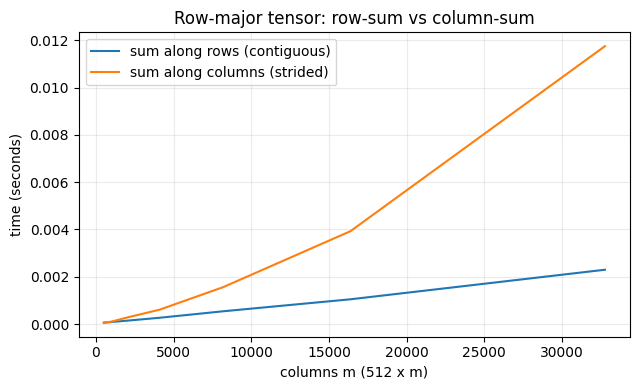

In [79]:
import time
import torch
import matplotlib.pyplot as plt

torch.set_num_threads(1)

def time_sum(A, dim, repeats=3):
    t0 = time.perf_counter()
    for _ in range(repeats):
        _ = torch.sum(A, dim=dim)
    t1 = time.perf_counter()
    return t1 - t0

rows = 512
cols_list = [512, 1024, 2048, 4096, 8192, 16384, 32768]
t_row, t_col = [], []

for cols in cols_list:
    A = torch.randn(rows, cols)
    t_row.append(time_sum(A, dim=1))  # contiguous
    t_col.append(time_sum(A, dim=0))  # strided

plt.figure(figsize=(6.5, 4.0))
plt.plot(cols_list, t_row, label="sum along rows (contiguous)")
plt.plot(cols_list, t_col, label="sum along columns (strided)")
plt.xlabel("columns m (512 x m)")
plt.ylabel("time (seconds)")
plt.title("Row-major tensor: row-sum vs column-sum")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig("figures/memory_layout_efficiency.png", dpi=200, bbox_inches="tight")



The row-major layout is faster because the inner loop hits contiguous memory. The column-major layout forces strided access and more cache misses.

This loop is intentionally slow to isolate the memory layout effect. In real code, you should use vectorized kernels.

![Row-major loop time by memory layout](figures/memory_layout_efficiency.png)
*Figure 3.7: Row-major access is faster on row-major data because the inner loop walks contiguous memory. On column-major data the same loop jumps by a stride and slows down as the matrix grows.*

#### Matmul order: $A(BC)$ vs $(AB)C$

Matrix multiplication is associative mathematically, but not computationally.

Let:

- $A \in \mathbb{R}^{m \times n}$,
- $B \in \mathbb{R}^{n \times p}$,
- $C \in \mathbb{R}^{p \times q}$.

The flop counts differ:

- $(AB)C$ costs about $mnp + mpq$ multiply-adds,
- $A(BC)$ costs about $npq + mnq$ multiply-adds.

The difference can be huge.

**Figure 3.6: associativity changes intermediate sizes.**  
![Matmul associativity cost](figures/matmul_associativity_cost.png)
*Figure 3.6: The intermediate matrix in $(AB)C$ has shape $m \times p$. The intermediate in $A(BC)$ has shape $n \times q$. You want the smaller intermediate when possible.*

A concrete timing example (average over 3 runs):



In [80]:
import time
import torch

torch.manual_seed(0)

m, n, p, q = 512, 512, 8, 512

A = torch.randn(m, n)
B = torch.randn(n, p)
C = torch.randn(p, q)

def avg_time(fn, repeats=3):
    times = []
    out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = fn()
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return sum(times) / len(times), out

t_ab, X1 = avg_time(lambda: (A @ B) @ C, repeats=3)
t_bc, X2 = avg_time(lambda: A @ (B @ C), repeats=3)

print("max diff:", (X1 - X2).abs().max().item())
print("avg (AB)C time (s):", t_ab)
print("avg A(BC) time (s):", t_bc)

# Example output (your times will differ):
# max diff: 0.0
# avg (AB)C time (s): 0.03
# avg A(BC) time (s): 0.35


max diff: 0.000457763671875
avg (AB)C time (s): 8.426366063455741e-05
avg A(BC) time (s): 0.00018765265122056007



The outputs match (up to floating point), but runtime differs because you changed the cost profile.

One might think “PyTorch will figure this out automatically.” However, matrix multiplication order is not generally optimized away for you. You must choose the parentheses.



In [81]:
# accumulation exercise moved above



### 4.9 Devices: CPU, GPU, MPS, TPU

By default, tensors live on CPU.



In [82]:
import torch

x = torch.randn(3)
print("device:", x.device)

# Output:
# device: cpu


device: cpu



You can move tensors to a device with `.to(device)`. In PyTorch, `cuda` is used to name NVIDIA GPUs (e.g., `cuda:0` for the first GPU).



In [83]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
x = torch.randn(3).to(device)

print("device:", x.device)

# Example output:
# device: cuda:0


device: cpu



Newer Macs may have an `mps` device. In my experience, MPS support is fragile! If you are on a Mac and you hit mysterious runtime errors, the first debugging step is often: run on CPU or on a CUDA machine.



In [84]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

x = torch.randn(3).to(device)
print("device:", x.device)

# Example output:
# device: mps


device: mps:0



Other devices exist (TPUs, etc.), typically via additional libraries (e.g., `torch_xla` in Colab). We will not rely on them in this course.

We'll return to this later on in the course, but if you want a concrete GPU mental model, see:

- <https://damek.github.io/random/basic-facts-about-gpus/>




